In [3]:
pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 39.2 MB/s eta 0:00:00m eta 0:00:010:01:01
Note: you may need to restart the kernel to use updated packages.


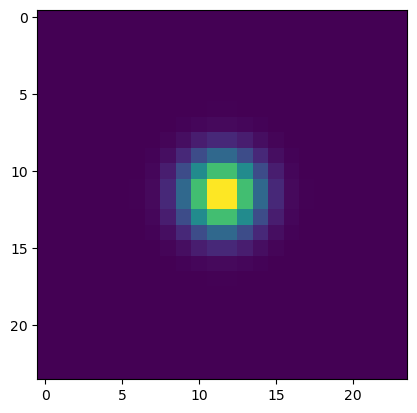

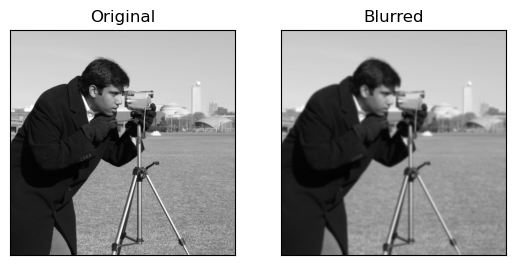

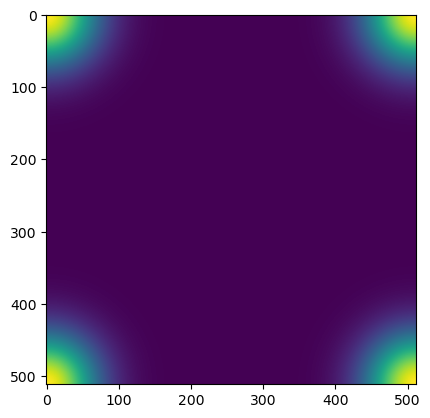

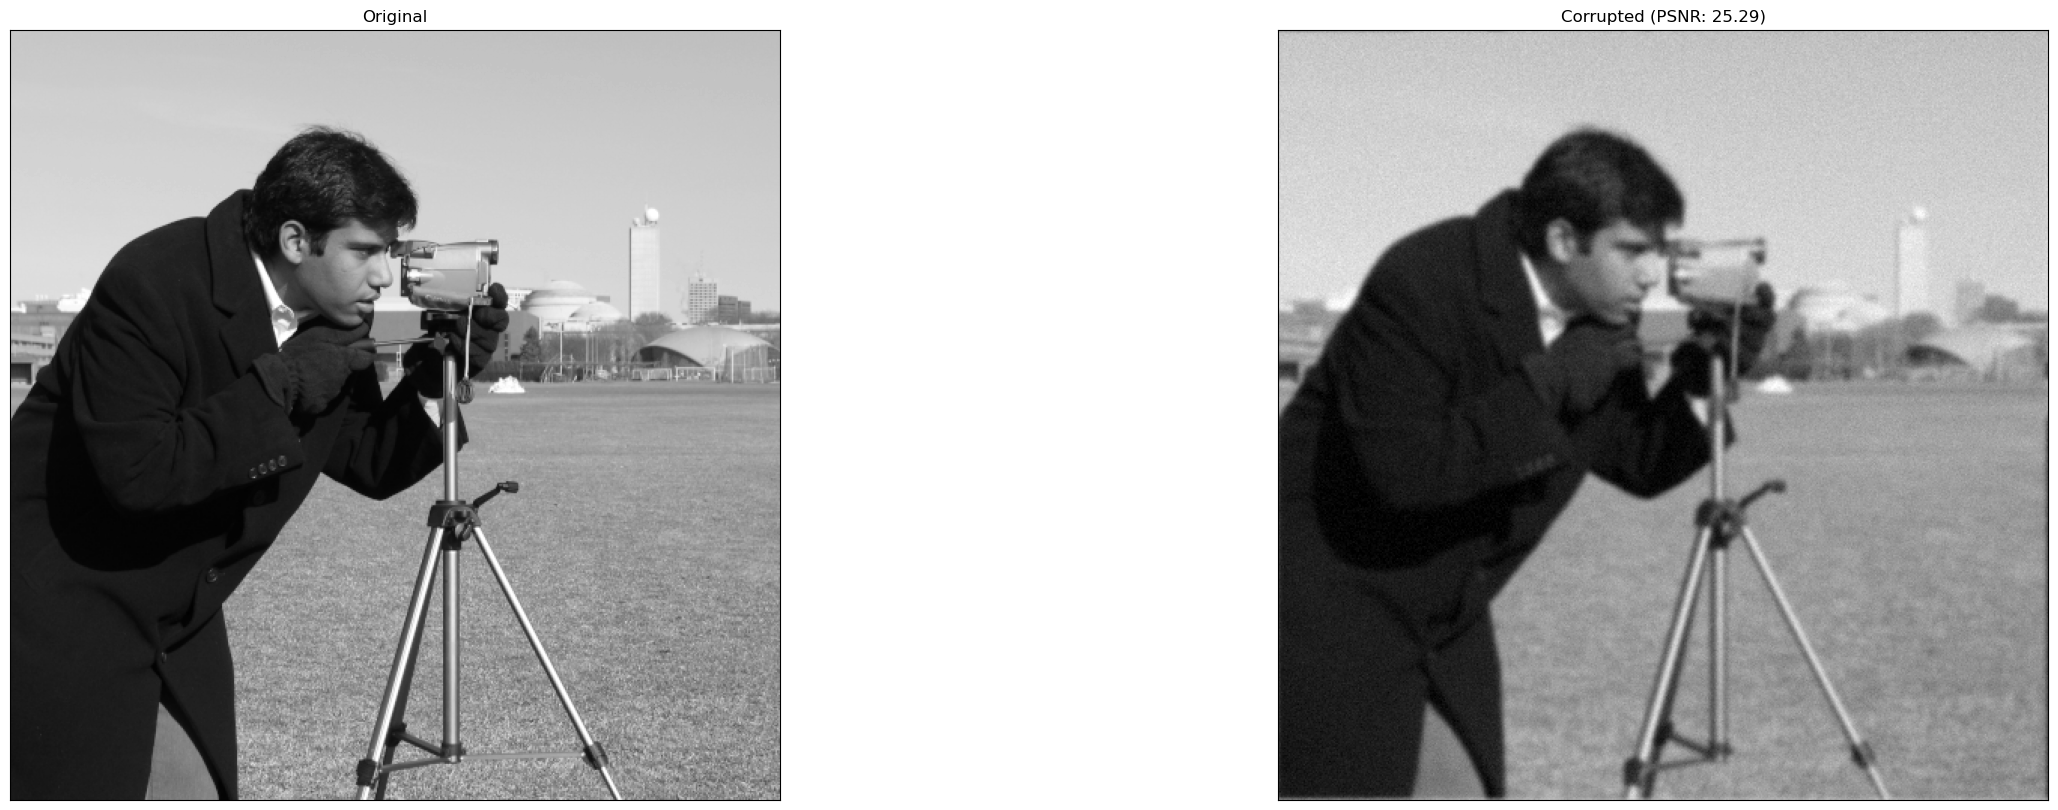

In [5]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, metrics
from scipy import signal
from numpy import fft
from utils import psf_fft, A, AT, gaussian_kernel
from utils_SR import A as A_SR, AT as AT_SR, totvar, grad_totvar

# Esercizio 1.1: Problema test
# Immagine in floating point con valori tra 0 e 1
X = data.camera().astype(np.float64) / 255.0
m, n = X.shape

# Genera il filtro di blur
k = gaussian_kernel(24, 3)
plt.imshow(k)
plt.show()

# Blur with openCV
X_blurred = cv.filter2D(X, -1, k)
plt.subplot(121).imshow(X, cmap='gray', vmin=0, vmax=1)
plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122).imshow(X_blurred, cmap='gray', vmin=0, vmax=1)
plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.show()

# Blur with FFT
K = psf_fft(k, 24, X.shape)
plt.imshow(np.abs(K))
plt.show()

X_blurred = np.real(fft.ifft2(K * fft.fft2(X)))

# Genera il rumore
sigma = 0.02
np.random.seed(42)
noise = np.random.normal(scale=sigma, size=X.shape)

# Aggiungi blur e rumore
y = X_blurred + noise
PSNR = metrics.peak_signal_noise_ratio(X, y)
ATy = AT(y, K)

# Visualizziamo i risultati
plt.figure(figsize=(30, 10))
plt.subplot(121).imshow(X, cmap='gray', vmin=0, vmax=1)
plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122).imshow(y, cmap='gray', vmin=0, vmax=1)
plt.title(f'Corrupted (PSNR: {PSNR:.2f})')
plt.xticks([]), plt.yticks([])
plt.show()

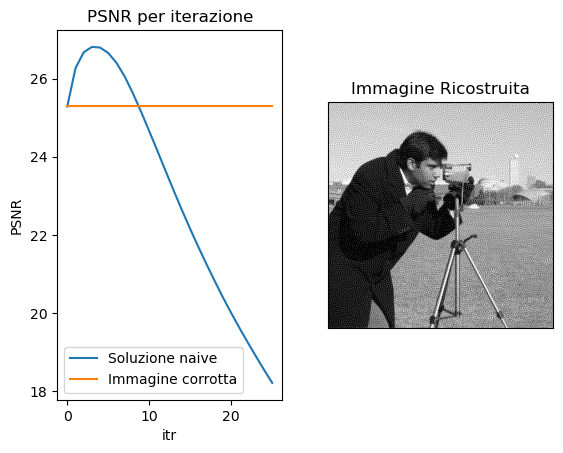

In [7]:
# Esercizio 1.2: Soluzione naive
from scipy.optimize import minimize

# Funzione da minimizzare
def f(x):
    x = x.reshape((m, n))
    Ax = A(x, K)
    return 0.5 * np.sum(np.square(Ax - y))

# Gradiente della funzione da minimizzare
def df(x):
    x = x.reshape((m, n))
    ATAx = AT(A(x, K), K)
    d = ATAx - ATy
    return d.reshape(m * n)

# Minimizzazione della funzione
x0 = y.reshape(m * n)
max_iter = 25
res = minimize(f, x0, method='CG', jac=df, options={'maxiter': max_iter, 'return_all': True})

# Per ogni iterazione calcola il PSNR rispetto all'originale
PSNR = np.zeros(max_iter + 1)
for k, x_k in enumerate(res.allvecs):
    PSNR[k] = metrics.peak_signal_noise_ratio(X, x_k.reshape(X.shape))

# Risultato della minimizzazione
X_res = res.x.reshape((m, n))

# PSNR dell'immagine corrotta rispetto all'originale
starting_PSNR = np.full(PSNR.shape[0], metrics.peak_signal_noise_ratio(X, y))

# Visualizziamo i risultati
ax2 = plt.subplot(1, 2, 1)
ax2.plot(PSNR, label="Soluzione naive")
ax2.plot(starting_PSNR, label="Immagine corrotta")
plt.legend()
plt.title('PSNR per iterazione')
plt.ylabel("PSNR")
plt.xlabel('itr')
plt.subplot(1, 2, 2).imshow(X_res, cmap='gray', vmin=0, vmax=1)
plt.title('Immagine Ricostruita')
plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
# Esercizio 1.3: Soluzione regolarizzata
# Funzione da minimizzare
def f(x, L):
    nsq = np.sum(np.square(x))
    x = x.reshape((m, n))
    Ax = A(x, K)
    return 0.5 * np.sum(np.square(Ax - y)) + 0.5 * L * nsq

# Gradiente della funzione da minimizzare
def df(x, L):
    Lx = L * x
    x = x.reshape(m, n)
    ATAx = AT(A(x, K), K)
    d = ATAx - ATy
    return d.reshape(m * n) + Lx

x0 = y.reshape(m * n)
lambdas = [0.01, 0.03, 0.04, 0.06]
PSNRs = []
images = []

# Ricostruzione per diversi valori del parametro di regolarizzazione
for i, L in enumerate(lambdas):
    # Esegui la minimizzazione con al massimo 50 iterazioni
    max_iter = 50
    res = minimize(f, x0, (L), method='CG', jac=df, options={'maxiter': max_iter})

    # Aggiungi la ricostruzione nella lista images
    X_curr = res.x.reshape(X.shape)
    images.append(X_curr)

    # Stampa il PSNR per il valore di lambda attuale
    PSNR = metrics.peak_signal_noise_ratio(X, X_curr)
    PSNRs.append(PSNR)
    print(f'PSNR: {PSNR:.2f} (λ = {L:.2f})')

# Visualizziamo i risultati
plt.plot(lambdas, PSNRs)
plt.title('PSNR per λ')
plt.ylabel("PSNR")
plt.xlabel('λ')
plt.show()

plt.figure(figsize=(30, 10))

plt.subplot(1, len(lambdas) + 2, 1).imshow(X, cmap='gray', vmin=0, vmax=1)
plt.title("Originale")
plt.xticks([]), plt.yticks([])
plt.subplot(1, len(lambdas) + 2, 2).imshow(y, cmap='gray', vmin=0, vmax=1)
plt.title("Corrotta")
plt.xticks([]), plt.yticks([])

for i, L in enumerate(lambdas):
    plt.subplot(1, len(lambdas) + 2, i + 3).imshow(images[i], cmap='gray', vmin=0, vmax=1)
    plt.title(f"Ricostruzione (λ = {L:.2f})")
plt.show()


PSNR: 26.26 (λ = 0.01)
PSNR: 26.86 (λ = 0.03)
PSNR: 26.47 (λ = 0.04)
